In [1]:
import os
import sys
from pyspark.sql.types import StringType, StructType
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
import time
spark_name = os.environ.get('SPARK_HOME',None)
if not spark_name:
    raise ValueErrorError('spark环境没有配置好')
sys.path.insert(0,os.path.join(spark_name,'python'))
sys.path.insert(0,os.path.join(spark_name,'python/lib/py4j-0.10.4-src.zip'))
exec(open(os.path.join(spark_name,'python/pyspark/shell.py')).read())


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.0.0
      /_/

Using Python version 3.8.3 (default, Jun  1 2020 17:43:00)
SparkSession available as 'spark'.


In [ ]:
start_time = time.time()
json_df  =  spark.read.option("multiLine", True).option("mode", "PERMISSIVE").json("./data/ditiller_comment_final_0715.json")
print(f"威士忌Schema:")
json_df .printSchema()
print(f"資料總比數: {json_df .count()}")
print("使用時間: %s seconds " % (time.time() - start_time))

In [10]:
df = json_df.toPandas()

In [11]:
df

,comment,whiskey_name
0,"((4.0, null, bignocowski), (4.0, On our trip l...",caol-ila-2004-connoisseurs-choice-gordon-macphail
1,"((4.5, So good, RBrooks2010), (4.75, null, bru...",barrell-dovetail-125-24-proof
2,"((3.0, Soirée Whisky 29!juin 2017 Choisie la p...",the-whistler-natural-cask-strength-7-year
3,"((1.0, A gimic, but fun one, NoMoreMrCivilGuy)...",georgia-moon-corn-whiskey
4,"((3.25, null, zcustodio), (4.0, This is a very...",jeremiah-weed
...,...,...
9234,"((4.25, null, Lemkin), (3.75, The Senator is a...",the-senator-summer-2019-batch
9235,"((5.0, tried at Jack Rose bar the 1993 year ag...",aberfeldy-14-year-old-1994-old-malt-cask
9236,"((3.0, null, clearhunter), (3.0, null, William...",islay-mist-12
9237,"((4.0, null, bdblash), (3.75, null, Gajem-Wisc...",timekeeper-distillery-straight-bourbon-whiskey


In [12]:
from tqdm import tqdm
result_list = list()
comment_col = ['score', 'text', 'user_name']

for idx in tqdm(range(len(df))):
    df_dict = df.iloc[idx,:].to_dict()
    for i in range(len(df_dict['comment'])):
        try:
            temp_dict = dict()
            temp_dict['whiskey_name'] = df_dict['whiskey_name']
            temp_dict['score'] = df_dict['comment'][i]['score']
            temp_dict['text'] = df_dict['comment'][i]['text']
            temp_dict['user_name'] = df_dict['comment'][i]['user_name']
            result_list.append(temp_dict)
        except:
            pass

100%|██████████| 9239/9239 [00:18<00:00, 504.35it/s]


In [18]:
import pandas as pd


In [21]:
new_df = pd.DataFrame(result_list)
new_df.to_csv("./data/ditiller_comment_final_0715.csv",index=None)

In [30]:
df_csv = spark.read.format("csv").option("header", "true").load("./data/ditiller_comment_final_0715.csv")

In [31]:
df_csv.show()

+--------------------+-----+--------------------+--------------------+
|        whiskey_name|score|                text|           user_name|
+--------------------+-----+--------------------+--------------------+
|caol-ila-2004-con...|  4.0|                null|         bignocowski|
|caol-ila-2004-con...|  4.0|On our trip last ...|   Dreaming-of-Islay|
|caol-ila-2004-con...|  4.0|The beauty and ch...|       Slainte-Mhath|
|caol-ila-2004-con...| 2.25|                null|                 tze|
|caol-ila-2004-con...| 4.25|Clean, strong, an...|       Bruce-Hodgson|
|caol-ila-2004-con...| 3.75|                null|Piervincenzo-Di-G...|
|caol-ila-2004-con...|  3.5|                null|     whiskeywinebeer|
|caol-ila-2004-con...|  3.0|                null|     Roberto-Agnello|
|caol-ila-2004-con...|  4.0|Beach  aroma of b...| PBMichiganWolverine|
|caol-ila-2004-con...|  4.0|                null|           dee_hamma|
|caol-ila-2004-con...|  4.0|                null|        Fionn-Kirwan|
|barre

In [32]:
df_csv.createOrReplaceTempView("wine_name")
some_user = spark.sql("SELECT * FROM wine_name WHERE user_name='bignocowski'")

In [34]:
some_user.show()

+--------------------+-----+----+-----------+
|        whiskey_name|score|text|  user_name|
+--------------------+-----+----+-----------+
|caol-ila-2004-con...|  4.0|null|bignocowski|
|          dalmore-15|  4.0|null|bignocowski|
|jura-diurachs-own...| 4.25|null|bignocowski|
|glendronach-parli...| 4.25|null|bignocowski|
|           hibiki-17|  4.5|null|bignocowski|
|glenglassaugh-evo...| 3.75|null|bignocowski|
|kilchoman-sanaig-...|  3.5|null|bignocowski|
|kilchoman-sautern...|  3.5|null|bignocowski|
|         yamazaki-12|  4.5|null|bignocowski|
+--------------------+-----+----+-----------+



In [35]:
dst_users = spark.sql("SELECT  DISTINCT user_name FROM wine_name")
dst_users.show()

+--------------------+
|           user_name|
+--------------------+
|                 EMW|
|                  LT|
|        Julian-Longo|
|           DanCaruso|
|             rumawet|
|         Ken-Hudgins|
|                 CwD|
|            dwbailey|
|           weloveosu|
|       Mazdaspeedrex|
|           caleb9224|
|Jean-Francois-Filion|
|            rolugomi|
|       Elliot-Walker|
|              cce525|
|         Jon-Gardner|
|        bomexeclipse|
|     Michael-Gillett|
|           SirBoozie|
|           Stoicorum|
+--------------------+
only showing top 20 rows



In [36]:
dst_users.count()

73283

In [37]:
type(dst_users)

pyspark.sql.dataframe.DataFrame

In [41]:
usr_list = [str(row.user_name) for row in dst_users.collect()]

In [44]:
for user in  usr_list:
    print(spark.sql(f"SELECT * FROM wine_name WHERE user_name='{str(user)}'").show())

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|the-macallan-fine...|  5.0|null|      EMW|
|     dewar-s-12-year|  4.0|null|      EMW|
|the-macallan-fine...|  5.0|null|      EMW|
|          jameson-12|  4.0|null|      EMW|
|   powers-gold-label|  3.0|null|      EMW|
|knappogue-castle-...|  2.0|null|      EMW|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|the-macallan-fine...|  4.0|null|       LT|
|the-macallan-cask...|  4.0|null|       LT|
|     the-macallan-18|  4.0|null|       LT|
|the-macallan-fine...|  5.0|null|       LT|
|the-glenlivet-mas...|  4.0|null|       LT|
|the-glenlivet-16-...|  4.0|null|       LT|
|    yamazaki-10-year|  4.0|null|       LT|
|royal-brackla-12-...|  4.0|null|       LT|
|  glen-moray-16-year|  4.0|null|       LT|
|the-macallan-ambe...|  4.

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|jack-daniel-s-sin...| 3.75|null|caleb9224|
| sagamore-spirit-rye|  4.0|null|caleb9224|
|     dewar-s-12-year| 3.75|null|caleb9224|
| jefferson-s-reserve| 3.25|null|caleb9224|
|             jameson|  2.0|null|caleb9224|
|johnnie-walker-bl...| 3.25|null|caleb9224|
|jameson-caskmates...| 2.25|null|caleb9224|
|old-forester-stat...| 4.25|null|caleb9224|
|chivas-regal-12-y...| 3.25|null|caleb9224|
|lagavulin-9-year-...|  4.5|null|caleb9224|
|johnnie-walker-a-...| 2.75|null|caleb9224|
|         smoky-black|  3.0|null|caleb9224|
|   ardmore-tradition| 3.75|null|caleb9224|
|          maker-s-46| 3.75|null|caleb9224|
|    laphroaig-select|  3.5|null|caleb9224|
|woodford-reserve-...| 4.75|null|caleb9224|
|highland-park-magnus| 2.75|null|caleb9224|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+--------------------+
|        whiske

+--------------------+-----+--------------------+---------------+
|        whiskey_name|score|                text|      user_name|
+--------------------+-----+--------------------+---------------+
|new-southern-revi...|  4.0|Great flavor and ...|Stephanie-Berry|
|collingwood-blend...|  4.0|Really tasty. Gre...|Stephanie-Berry|
|rua-american-sing...|  4.0|Very tasty. Rich ...|Stephanie-Berry|
|     elijah-craig-12|  4.0|Go-to bourbon. Gr...|Stephanie-Berry|
|the-singleton-of-...|  4.0|Extremely easy dr...|Stephanie-Berry|
|             oban-14|  5.0|Malty, tasty, ult...|Stephanie-Berry|
|     the-macallan-12|  5.0|Spicy for a scotc...|Stephanie-Berry|
|j-j-neukomm-misso...|  4.0|Woody, slightly s...|Stephanie-Berry|
|        laphroaig-10|  2.0|Interesting, but ...|Stephanie-Berry|
|  balcones-baby-blue|  5.0|Sweet and mellow....|Stephanie-Berry|
|port-dundas-singl...|  3.0|Smooth and vanill...|Stephanie-Berry|
|         bulleit-rye|  3.0|A little sweeter ...|Stephanie-Berry|
|        j

+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|the-singleton-of-...| 3.75|null|Ale-Pienso|
+--------------------+-----+----+----------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|ole-smoky-peach-m...| null|null|pkripper3|
|jim-beam-black-8-...| null|null|pkripper3|
|black-eagle-bourb...| null|null|pkripper3|
|very-old-barton-8...| null|null|pkripper3|
|skrewball-peanut-...| null|null|pkripper3|
|           buck-horn| null|null|pkripper3|
|evan-williams-bla...| null|null|pkripper3|
|ole-smoky-tenness...| null|null|pkripper3|
|ole-smoky-tenness...| null|null|pkripper3|
|neeley-family-dis...| null|null|pkripper3|
|            lonehand| null|null|pkripper3|
|ole-smoky-peach-w...| null|null|pkripper3|
|ole-smoky-tenness...| null|null|pkripper3|
|palmetto-moonshin...| null|null|pkripper3|
|palmetto-moonshin...

+--------------------+-----+----+------------+
|        whiskey_name|score|text|   user_name|
+--------------------+-----+----+------------+
|russell-s-reserve...|  4.5|null|tomwambsgans|
|wild-turkey-rare-...|  4.0|null|tomwambsgans|
|     wild-turkey-101|  3.0|null|tomwambsgans|
+--------------------+-----+----+------------+

None
+--------------------+-----+--------------------+------------+
|        whiskey_name|score|                text|   user_name|
+--------------------+-----+--------------------+------------+
|russell-s-reserve...| null|My local store Di...|smittyhopson|
+--------------------+-----+--------------------+------------+

None
+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|bushmills-black-bush|  4.0|null|Sonofanump|
|        old-forester|  2.5|null|Sonofanump|
|  fistful-of-bourbon| 3.75|null|Sonofanump|
|    old-forester-rye|  4.0|null|Sonofanump|
|bulleit-bourbon-b...| 4.25|n

+--------------------+-----+--------------------+----------+
|        whiskey_name|score|                text| user_name|
+--------------------+-----+--------------------+----------+
|the-glenlivet-21-...|  5.0|                null|ijbrowning|
| corsair-ryemageddon|  4.0|                null|ijbrowning|
|bushmills-10-year...|  4.0|                null|ijbrowning|
|  midleton-very-rare|  5.0|                null|ijbrowning|
|dad-s-hat-pennsyl...|  4.0|                null|ijbrowning|
|corsair-triple-smoke|  4.0|A smokey beginnin...|ijbrowning|
|  canadian-club-1858|  3.0|                null|ijbrowning|
|knappogue-castle-...|  5.0|                null|ijbrowning|
+--------------------+-----+--------------------+----------+

None
+--------------------+-----+----+----------------+
|        whiskey_name|score|text|       user_name|
+--------------------+-----+----+----------------+
|the-glenlivet-21-...|  5.0|null|Clerin-Fernandez|
|the-macallan-sele...|  3.0|null|Clerin-Fernandez|
+------

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|the-famous-grouse...|  3.5|null|raf_panis|
|nikka-whisky-from...| 4.25|null|raf_panis|
|  george-dickel-no-8|  3.0|null|raf_panis|
|teeling-single-gr...|  4.0|null|raf_panis|
|kirin-fuji-sanrok...|  4.0|null|raf_panis|
|compass-box-oak-c...|  4.0|null|raf_panis|
|roe-co-irish-whiskey|  3.5|null|raf_panis|
|gouden-carolus-si...| 3.75|null|raf_panis|
|knockando-21-year...| 3.25|null|raf_panis|
|johnnie-walker-ex...| 3.25|null|raf_panis|
|compass-box-spice...| 4.25|null|raf_panis|
|scallywag-blended...|  3.5|null|raf_panis|
|wild-turkey-rare-...|  4.0|null|raf_panis|
|the-balvenie-doub...| 3.75|null|raf_panis|
|        maker-s-mark|  3.5|null|raf_panis|
|benriach-cask-str...|  4.0|null|raf_panis|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+------------+
|        whiskey_name|score|text|   user_name|
+-------------------

+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|tx-straight-bourb...|  3.0|Decent. Kinda pri...|   c3hevs|
|     elijah-craig-12|  5.0|Definitely my go ...|   c3hevs|
|   j-r-ewing-bourbon|  3.0|                null|   c3hevs|
|seagram-s-seven-c...|  2.0|                null|   c3hevs|
+--------------------+-----+--------------------+---------+

None
+--------------------+-----+--------+---------+
|        whiskey_name|score|    text|user_name|
+--------------------+-----+--------+---------+
|      talisker-storm|  3.5|pleasant| PanSavva|
|jack-daniel-s-191...| 2.75|    null| PanSavva|
+--------------------+-----+--------+---------+

None
+---------------+-----+----+--------------+
|   whiskey_name|score|text|     user_name|
+---------------+-----+----+--------------+
|tatoosh-whiskey|  2.0|null|Matt-Cantasano|
+---------------+-----+----+--------------+


+--------------------+-----+----+-----------+
|        whiskey_name|score|text|  user_name|
+--------------------+-----+----+-----------+
|willett-pot-still...|  3.0|null|karlosralph|
|blade-and-bow-bou...|  4.0|null|karlosralph|
|            stagg-jr| 3.25|null|karlosralph|
+--------------------+-----+----+-----------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|willett-pot-still...|  2.5|It’s ok... expect...|   Brad-C|
|jim-beam-bonded-b...| 3.75|1st at 20/750ml t...|   Brad-C|
|basil-hayden-dark...|  3.0|Unusual and inter...|   Brad-C|
|elijah-craig-18-b...| 4.75|Only had it once,...|   Brad-C|
|calumet-farm-bourbon|  3.0|Sweet, spicy and ...|   Brad-C|
|i-w-harper-straig...|  3.0|I don’t know, it’...|   Brad-C|
|  balcones-brimstone|  1.0|This whiskey is n...|   Brad-C|
|1792-ridgemont-re...|  4.0|Spicy and peppery...|   Brad-C|
|knob-creek-

+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|   kilkerran-12-year|  4.0|null|birkandrmz|
|kavalan-solist-sh...|  5.0|null|birkandrmz|
|lot-no-40-canadia...|  4.0|null|birkandrmz|
|wiser-s-last-barrels|  5.0|null|birkandrmz|
|mortlach-15-year-...|  4.0|null|birkandrmz|
|bunnahabhain-eiri...|  5.0|null|birkandrmz|
+--------------------+-----+----+----------+

None
+-----------------+-----+----+------------------+
|     whiskey_name|score|text|         user_name|
+-----------------+-----+----+------------------+
|kilkerran-12-year|  3.0|null|kylepreferswhiskey|
+-----------------+-----+----+------------------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|kirkland-18-year-...|  3.0|null|   matchu|
|johnnie-walker-bl...|  4.0|null|   matchu|
|wigle-organic-pen...|  3.5|null|   matchu|
|kirkland-small-ba...| 3

+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|high-west-yippee-...|  4.0|null|Eric-Tufte|
|st-george-single-...|  3.0|null|Eric-Tufte|
|   amrut-single-malt|  2.0|null|Eric-Tufte|
+--------------------+-----+----+----------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|  royal-lochnagar-12|  4.0|null| Dugbrown|
|the-balvenie-sing...|  4.0|null| Dugbrown|
+--------------------+-----+----+---------+

None
+--------------------+-----+---------+------------+
|        whiskey_name|score|     text|   user_name|
+--------------------+-----+---------+------------+
|buffalo-trace-bou...|  4.0|     null|kingcrimson2|
|   cleveland-bourbon|  1.0|     null|kingcrimson2|
|jim-beam-bonded-b...|  2.0|     null|kingcrimson2|
|knob-creek-9-year...|  2.0|     null|kingcrimson2|
|jim-beam-black-la...|  3.0|     null|kingcri

+--------------------+-----+------------+---------+
|        whiskey_name|score|        text|user_name|
+--------------------+-----+------------+---------+
|the-glenlivet-mas...| null|Good scotch.|   johnva|
|         deanston-12|  3.0|        null|   johnva|
|johnnie-walker-go...|  4.0|        null|   johnva|
+--------------------+-----+------------+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|  macallan-rare-cask|  5.0|null| jomarbla|
|         smoky-black|  2.0|null| jomarbla|
| paddy-irish-whiskey|  1.0|null| jomarbla|
|j-b-rare-blended-...|  1.0|null| jomarbla|
+--------------------+-----+----+---------+

None
+------------------+-----+----+---------+
|      whiskey_name|score|text|user_name|
+------------------+-----+----+---------+
|macallan-rare-cask| 2.25|null|   jpttsn|
+------------------+-----+----+---------+

None
+--------------------+-----+----+--------------+
|      

+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|glenfiddich-reser...|  4.0|Had in Sweden wit...|  dvoinmd|
|maker-s-mark-wood...|  3.5|Strong, vanilla, ...|  dvoinmd|
|      glenfiddich-18|  5.0|                null|  dvoinmd|
|knob-creek-single...|  4.0|More of a bite th...|  dvoinmd|
+--------------------+-----+--------------------+---------+

None
+--------------------+-----+----+-----------+
|        whiskey_name|score|text|  user_name|
+--------------------+-----+----+-----------+
|crown-royal-north...|  3.0|null|mitchgoldie|
|  canadian-club-1858|  2.0|null|mitchgoldie|
+--------------------+-----+----+-----------+

None
+--------------------+-----+----+---------------+
|        whiskey_name|score|text|      user_name|
+--------------------+-----+----+---------------+
|makers-mark-priva...| 4.75|null|JonathanJentlie|
+--------------------+-----+----

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|glen-garioch-12-year|  3.0|null| Vladamia|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|john-s-alabama-si...|  4.0|null| jgentile|
|glenfiddich-proje...|  4.0|null| jgentile|
|    highland-park-15|  3.0|null| jgentile|
|aberlour-16-year-old|  4.0|null| jgentile|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|jim-beam-signatur...|  4.0|null|      SGT|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+-----------+
|        whiskey_name|score|text|  user_name|
+--------------------+-----+----+-----------+
|wild-turkey-longb...|  4.0|null|Davis-Watts|
+-----

+---------------+-----+----+-----------+
|   whiskey_name|score|text|  user_name|
+---------------+-----+----+-----------+
|tomatin-12-year|  3.0|null|Rmarkwell18|
+---------------+-----+----+-----------+

None
+---------------+-----+----+----------------+
|   whiskey_name|score|text|       user_name|
+---------------+-----+----+----------------+
|tomatin-12-year| 4.25|null|Michael-Akushsky|
+---------------+-----+----+----------------+

None
+--------------------+-----+--------------------+------------------+
|        whiskey_name|score|                text|         user_name|
+--------------------+-----+--------------------+------------------+
|     tomatin-12-year|  4.0|Delicious - Bette...|Asger-Agerbo-Krogh|
| deanston-virgin-oak|  3.0|                null|Asger-Agerbo-Krogh|
|duncan-taylor-the...|  3.0|                null|Asger-Agerbo-Krogh|
|big-peat-blended-...|  2.0|                null|Asger-Agerbo-Krogh|
+--------------------+-----+--------------------+------------------+



+--------------------+-----+----+--------------------+
|        whiskey_name|score|text|           user_name|
+--------------------+-----+----+--------------------+
|talisker-distille...|  5.0|null|Deb-Travis-Boisso...|
|jim-beam-devil-s-cut|  3.0|null|Deb-Travis-Boisso...|
|old-bardstown-est...|  3.0|null|Deb-Travis-Boisso...|
+--------------------+-----+----+--------------------+

None
+--------------------+-----+--------------------+--------------+
|        whiskey_name|score|                text|     user_name|
+--------------------+-----+--------------------+--------------+
|blanton-s-special...|  4.0|                null|ridedrinksleep|
|       jura-prophecy|  4.0|                null|ridedrinksleep|
|santis-malt-appen...|  2.0|Disappointing. Ha...|ridedrinksleep|
|yamazaki-distille...|  4.0|                null|ridedrinksleep|
+--------------------+-----+--------------------+--------------+

None
+--------------------+-----+----+-------------+
|        whiskey_name|score|text|  

+--------------------+-----+----+--------------+
|        whiskey_name|score|text|     user_name|
+--------------------+-----+----+--------------+
|h-clark-distiller...|  3.0|null|Mr_Swartzfager|
|hunter-s-select-b...|  5.0|null|Mr_Swartzfager|
+--------------------+-----+----+--------------+

None
+--------------------+-----+----+------------+
|        whiskey_name|score|text|   user_name|
+--------------------+-----+----+------------+
|laphroaig-triple-...|  5.0|null|Stuart-Smith|
|    speyburn-10-year|  3.0|null|Stuart-Smith|
+--------------------+-----+----+------------+

None
+------------+-----+----+-----------+
|whiskey_name|score|text|  user_name|
+------------+-----+----+-----------+
| deanston-12|  4.0|null|jesseharris|
+------------+-----+----+-----------+

None
+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|ranger-creek-rimfire|  4.0|null|Awilliford|
|sonoma-county-dis...|  4.0|null|Awi

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|johnnie-walker-ex...|  4.0|null|   Jess-F|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|george-t-stagg-bo...|  4.0|null| Auwisner|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+-------------+
|        whiskey_name|score|text|    user_name|
+--------------------+-----+----+-------------+
|writers-tears-pot...|  5.0|null|Darryl-Buckle|
+--------------------+-----+----+-------------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|four-roses-small-...|  3.0|null| JABJitsu|
+--------------------+-----+----+---------+

None
+--------------+-----+------+-----------+
|  whiskey_name|score|  text|  use

+--------------------+-----+--------------------+-----------+
|        whiskey_name|score|                text|  user_name|
+--------------------+-----+--------------------+-----------+
|the-macallan-fine...| 3.25|                null|boudreaux31|
|          dalmore-15|  4.0|                null|boudreaux31|
|glenfiddich-21-gr...| 2.75|                null|boudreaux31|
|   glengoyne-18-year| 3.25|                null|boudreaux31|
|bruichladdich-isl...|  3.5|A great taste for...|boudreaux31|
|bowmore-cask-stre...|  3.5|                null|boudreaux31|
|     the-macallan-18|  3.0|                null|boudreaux31|
|      bowmore-legend| 3.25|                null|boudreaux31|
|the-balvenie-made...| 2.75|                null|boudreaux31|
|ardbeg-airigh-nam...|  4.0|                null|boudreaux31|
|        glengoyne-10| 2.75|                null|boudreaux31|
|      glenfarclas-12| 2.75|                null|boudreaux31|
|      glenfarclas-12|  3.0|                null|boudreaux31|
| bowmor

+------------------+-----+--------------------+---------+
|      whiskey_name|score|                text|user_name|
+------------------+-----+--------------------+---------+
|1835-texas-bourbon|  4.0|Extremely smooth....| squatchy|
+------------------+-----+--------------------+---------+

None
+--------------------+-----+--------------------+------------+
|        whiskey_name|score|                text|   user_name|
+--------------------+-----+--------------------+------------+
|  crown-royal-deluxe|  2.0|                null|WhiskeyTitan|
|ole-smoky-peach-m...|  1.0|No peach flavor. ...|WhiskeyTitan|
|tom-s-foolery-bou...|  3.0|                null|WhiskeyTitan|
|jack-daniels-whit...|  4.0|                null|WhiskeyTitan|
|jim-beam-black-label|  2.0|                null|WhiskeyTitan|
| crown-royal-vanilla|  2.5|Vanilla flavor ta...|WhiskeyTitan|
|crown-royal-peach...|  4.5|Strong peach flav...|WhiskeyTitan|
|ole-smoky-salty-c...|  4.0|                null|WhiskeyTitan|
|         b

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|glenfiddich-21-gr...|  5.0|null|    Con_w|
|the-macallan-esta...|  5.0|null|    Con_w|
+--------------------+-----+----+---------+

None
+--------------+-----+----+-----------+
|  whiskey_name|score|text|  user_name|
+--------------+-----+----+-----------+
|hibiki-21-year|  5.0|null|Shane-Brown|
+--------------+-----+----+-----------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|      hibiki-21-year|  4.0|null|   kj1060|
|high-west-america...|  4.0|null|   kj1060|
|johnnie-walker-wh...|  5.0|null|   kj1060|
|defiance-high-rye...|  3.0|null|   kj1060|
|johnnie-walker-bl...|  3.0|null|   kj1060|
|johnnie-walker-swing|  2.0|null|   kj1060|
|johnnie-walker-bl...|  5.0|null|   kj1060|
|johnnie-walker-bl...|  3.0|null|   kj1060|
|johnnie-walker-is...|  4.0|null|   kj10

+-----------------+-----+----+----------+
|     whiskey_name|score|text| user_name|
+-----------------+-----+----+----------+
|crown-royal-black|  5.0|null|Topdolla86|
+-----------------+-----+----+----------+

None
+--------------------+-----+----+----------------+
|        whiskey_name|score|text|       user_name|
+--------------------+-----+----+----------------+
|kentucky-vintage-...|  3.0|null|Adam-Longueville|
| noah-s-mill-bourbon|  3.5|null|Adam-Longueville|
+--------------------+-----+----+----------------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|russell-s-reserve...| 3.75|null|cagough05|
|russell-s-reserve...| 4.25|null|cagough05|
|high-west-double-rye| 3.75|null|cagough05|
|     baker-s-bourbon| 3.75|null|cagough05|
|four-roses-small-...| 3.75|null|cagough05|
|henry-mckenna-sin...| 4.25|null|cagough05|
|asw-fiddler-georg...|  4.0|null|cagough05|
|george-dickel-bar...| 3.75|null

+--------------------+-----+--------------------+----------+
|        whiskey_name|score|                text| user_name|
+--------------------+-----+--------------------+----------+
|templeton-rye-map...|  5.0|Awesome. We are a...|Ladiesview|
|templeton-rye-bar...|  5.0|Just ...wow! Spla...|Ladiesview|
|templeton-rye-bar...|  5.0|Just buy this and...|Ladiesview|
|writers-tears-pot...|  5.0|Love it ! One of ...|Ladiesview|
+--------------------+-----+--------------------+----------+

None
+--------------------+-----+--------------------+---------------+
|        whiskey_name|score|                text|      user_name|
+--------------------+-----+--------------------+---------------+
|cold-spell-intens...| 2.25|Obviously not ama...|TheWhiskeyNinja|
|skrewball-peanut-...|  2.5|Almost burnt pean...|TheWhiskeyNinja|
|   two-stars-bourbon| 2.25|Moderately smooth...|TheWhiskeyNinja|
|johnnie-walker-wh...| 2.25|Bitter and cool o...|TheWhiskeyNinja|
|            lonehand|  2.5|For the price bu

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|wayne-gretzky-no-...|  2.0|null|      bgx|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|wayne-gretzky-no-...|  4.0|null|  blair39|
|pappy-van-winkle-...|  5.0|null|  blair39|
|crown-royal-75th-...|  3.0|null|  blair39|
|crown-royal-north...|  4.0|null|  blair39|
|the-macallan-ambe...|  4.0|null|  blair39|
|glen-garioch-12-year|  4.0|null|  blair39|
|glen-breton-rare-...|  4.0|null|  blair39|
|wayne-gretzky-no-...|  3.0|null|  blair39|
|johnnie-walker-go...|  4.0|null|  blair39|
|    speyburn-10-year|  3.0|null|  blair39|
|crown-royal-cask-...|  4.0|null|  blair39|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+-------------+
|        whiskey_name|score|text|    user_name|
+-----------

+--------------------+-----+--------------------+--------------+
|        whiskey_name|score|                text|     user_name|
+--------------------+-----+--------------------+--------------+
| sagamore-spirit-rye|  5.0|                null|Michael-Hussle|
|whistlepig-old-wo...|  4.0|                null|Michael-Hussle|
|whistlepig-old-wo...|  4.0|Very sweet finish...|Michael-Hussle|
|   jura-superstition|  5.0|                null|Michael-Hussle|
+--------------------+-----+--------------------+--------------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|kings-county-peat...|  2.5|Tasted nice by it...|  molespf|
|doc-52-cask-finis...| 3.75|Complex profile. ...|  molespf|
|       w-l-weller-12|  4.0|Spicy front with ...|  molespf|
|fiddler-unison-bo...|  3.5|Sweet front end. ...|  molespf|
|1792-single-barre...|  3.5|                null|  mol

+--------------------+-----+----+------------+
|        whiskey_name|score|text|   user_name|
+--------------------+-----+----+------------+
|high-west-america...|  4.0|null|benjabillion|
|yellow-spot-singl...|  5.0|null|benjabillion|
|aberlour-12-sherr...|  3.0|null|benjabillion|
|oban-limited-edit...|  4.0|null|benjabillion|
|      glenfarclas-17|  4.0|null|benjabillion|
|oban-distillers-e...|  4.0|null|benjabillion|
|the-glenrothes-vi...|  2.0|null|benjabillion|
+--------------------+-----+----+------------+

None
+--------------------+-----+----------+----------+
|        whiskey_name|score|      text| user_name|
+--------------------+-----+----------+----------+
|teacher-s-highlan...|  3.0|      null|winterkaos|
|          jameson-12|  4.0|      null|winterkaos|
|         talisker-25|  4.0|Favourite!|winterkaos|
|           sheep-dip|  3.0|      null|winterkaos|
+--------------------+-----+----------+----------+

None
+--------------------+-----+----+----------+
|        whiskey_n

+------------------+-----+----+---------+
|      whiskey_name|score|text|user_name|
+------------------+-----+----+---------+
|      redbreast-15|  5.0|null|  bkodish|
|midleton-very-rare|  5.0|null|  bkodish|
+------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|jefferson-s-reser...|  4.0|null|cmooreusm|
|pappy-van-winkle-...|  5.0|null|cmooreusm|
|jefferson-s-ocean...| null|null|cmooreusm|
+--------------------+-----+----+---------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|tullamore-d-e-w-1...| 4.75|Tastes sweetie, s...| Sinamics|
|          cutty-sark|  2.0|                null| Sinamics|
|grant-s-family-re...|  3.0|                null| Sinamics|
+--------------------+-----+--------------------+---------+

None
+-

+--------------------+-----+--------------------+---------------+
|        whiskey_name|score|                text|      user_name|
+--------------------+-----+--------------------+---------------+
|willett-pot-still...|  2.5|                null|Brad-A-Stephens|
|kavanagh-single-m...| 3.75|                null|Brad-A-Stephens|
|george-dickel-bot...|  4.5|The best of the G...|Brad-A-Stephens|
|very-old-st-nick-...|  4.5|                null|Brad-A-Stephens|
|widow-jane-lucky-...|  4.5|                null|Brad-A-Stephens|
|  michters-sour-mash| 4.25|                null|Brad-A-Stephens|
|w-l-weller-specia...|  3.0|                null|Brad-A-Stephens|
|george-dickel-bot...| 4.75|                null|Brad-A-Stephens|
|willett-family-es...|  4.5|                null|Brad-A-Stephens|
|widow-jane-12-yea...| 4.75|                null|Brad-A-Stephens|
|  w-l-weller-antique|  5.0|                null|Brad-A-Stephens|
|jefferson-s-reser...|  4.5|                null|Brad-A-Stephens|
+---------

+--------------------+-----+--------------------+-----------+
|        whiskey_name|score|                text|  user_name|
+--------------------+-----+--------------------+-----------+
|nikka-whisky-from...| 4.75|Once again, great...|Ron-Rollins|
+--------------------+-----+--------------------+-----------+

None
+--------------------+-----+----+------------+
|        whiskey_name|score|text|   user_name|
+--------------------+-----+----+------------+
|heaven-hill-bottl...| 4.25|null|Manny-Andaya|
|henry-mckenna-sin...|  4.5|null|Manny-Andaya|
|    burnside-bourbon| 3.75|null|Manny-Andaya|
|elijah-craig-smal...| 3.75|null|Manny-Andaya|
|wilderness-trail-...| 3.75|null|Manny-Andaya|
|     larceny-bourbon|  3.5|null|Manny-Andaya|
|      knob-creek-rye|  3.5|null|Manny-Andaya|
|george-dickel-bot...| 3.75|null|Manny-Andaya|
|george-dickel-bot...|  3.5|null|Manny-Andaya|
|smoke-wagon-small...| 3.75|null|Manny-Andaya|
|      redemption-rye| null|null|Manny-Andaya|
|redwood-empire-am...| 3.7

+--------------------+-----+----+-----------+
|        whiskey_name|score|text|  user_name|
+--------------------+-----+----+-----------+
|tullamore-dew-12-...|  4.0|null|cadejayhawk|
|  tx-blended-whiskey|  4.0|null|cadejayhawk|
|bib-tucker-small-...|  4.0|null|cadejayhawk|
|bulleit-bourbon-b...|  3.0|null|cadejayhawk|
+--------------------+-----+----+-----------+

None
+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|breaking-and-ente...|  4.0|null|Matt-Boles|
|russell-s-reserve...|  4.0|null|Matt-Boles|
|willett-explorato...|  5.0|null|Matt-Boles|
|fireside-colorado...|  2.0|null|Matt-Boles|
|koval-single-barr...|  4.0|null|Matt-Boles|
|goldrun-rye-calif...|  2.0|null|Matt-Boles|
|rebecca-creek-fin...|  3.0|null|Matt-Boles|
+--------------------+-----+----+----------+

None
+--------------------+-----+--------------------+-----------+
|        whiskey_name|score|                text|  user_name|
+

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|colonel-e-h-taylo...|  3.0|null|    Glhed|
|black-maple-hill-...|  3.0|null|    Glhed|
+--------------------+-----+----+---------+

None
+----------------+-----+----+---------+
|    whiskey_name|score|text|user_name|
+----------------+-----+----+---------+
|aultmore-12-year|  4.0|null| hardmaj1|
+----------------+-----+----+---------+

None
+--------------------+-----+----+-------------+
|        whiskey_name|score|text|    user_name|
+--------------------+-----+----+-------------+
|bowman-brothers-s...|  5.0|null|Brennan-Rhule|
|bowman-brothers-s...|  5.0|null|Brennan-Rhule|
|nikka-taketsuru-p...|  4.0|null|Brennan-Rhule|
+--------------------+-----+----+-------------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|b

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|green-spot-single...| 4.75|null|  ecarr13|
|     bulleit-bourbon| 3.75|null|  ecarr13|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|bunnahabhain-toit...|  4.0|null| Davy1982|
+--------------------+-----+----+---------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|knob-creek-single...|  4.0|Smoother than I w...| JediJoda|
+--------------------+-----+--------------------+---------+

None
+------------+-----+-----------------+-------------+
|whiskey_name|score|             text|    user_name|
+------------+-----+-----------------+-------------+
|  bowmore-15|  3.0|Very distinctive.|A

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|james-e-pepper-17...|  3.0|null| woodsant|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|straight-edge-bou...|  4.5|null|  pauln46|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+------------------+
|        whiskey_name|score|text|         user_name|
+--------------------+-----+----+------------------+
|straight-edge-bou...|  3.0|null|Robert-Greenstreet|
+--------------------+-----+----+------------------+

None
+------------+-----+----+-------------+
|whiskey_name|score|text|    user_name|
+------------+-----+----+-------------+
|laphroaig-10|  5.0|null|Mickey-Shealy|
+------------+-----+----+-------------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score

+------------+-----+----+--------------------+
|whiskey_name|score|text|           user_name|
+------------+-----+----+--------------------+
|black-velvet|  1.0|null|Christoffer-Bjerr...|
+------------+-----+----+--------------------+

None
+----------------+-----+----+---------+
|    whiskey_name|score|text|user_name|
+----------------+-----+----+---------+
|    black-velvet|  4.0|null|andpatrik|
|old-crow-bourbon|  3.0|null|andpatrik|
+----------------+-----+----+---------+

None
+--------------------+-----+-------------------+---------+
|        whiskey_name|score|               text|user_name|
+--------------------+-----+-------------------+---------+
|koval-single-barr...| null|costco 39.99 9/8/17|    blasr|
|the-glenlivet-18-...|  4.0|               null|    blasr|
+--------------------+-----+-------------------+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|koval-single-barr...

+--------------------+-----+--------------------+----------+
|        whiskey_name|score|                text| user_name|
+--------------------+-----+--------------------+----------+
|fireside-colorado...|  3.5|For the low price...|rksexton39|
|tim-smith-souther...| 0.75|High taste of moo...|rksexton39|
|ezra-brooks-90-pr...|  4.0|                null|rksexton39|
+--------------------+-----+--------------------+----------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|laphroaig-10-year...|  4.0|null|jeremiewi|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+-----------+
|        whiskey_name|score|text|  user_name|
+--------------------+-----+----+-----------+
|laphroaig-10-year...|  4.0|null|Anton-Kedin|
+--------------------+-----+----+-----------+

None
+--------------------+-----+----+-------------+
|        whiskey_name|score|text|    user_name|
+--------

+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|the-balvenie-doub...|  4.5|null|-------489|
+--------------------+-----+----+----------+

None
+----------------+-----+----+------------+
|    whiskey_name|score|text|   user_name|
+----------------+-----+----+------------+
|speyburn-10-year|  3.0|null|Chris-Hillis|
+----------------+-----+----+------------+

None
+--------------+-----+----+-----------+
|  whiskey_name|score|text|  user_name|
+--------------+-----+----+-----------+
|wild-turkey-81| 2.75|null|jjhendricks|
+--------------+-----+----+-----------+

None
+------------+-----+----+---------+
|whiskey_name|score|text|user_name|
+------------+-----+----+---------+
|ardbeg-an-oa|  5.0|null|    Ilu87|
+------------+-----+----+---------+

None
+--------------------+-----+----+------------+
|        whiskey_name|score|text|   user_name|
+--------------------+-----+----+------------+
|hale-and-bradf

+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|        black-grouse|  3.0|null|donnamarie|
|benromach-cask-st...|  4.0|null|donnamarie|
|mcclelland-s-sing...|  2.0|null|donnamarie|
|mcclelland-s-sing...|  3.0|null|donnamarie|
+--------------------+-----+----+----------+

None
+--------------------+-----+----+-----------+
|        whiskey_name|score|text|  user_name|
+--------------------+-----+----+-----------+
|        black-grouse|  3.0|null|Jay-Loehner|
|kavalan-classic-s...|  3.0|null|Jay-Loehner|
|kavalan-classic-s...|  4.0|null|Jay-Loehner|
|bowman-brothers-s...|  4.0|null|Jay-Loehner|
|        jura-10-year|  4.0|null|Jay-Loehner|
|redbreast-12-cask...|  3.0|null|Jay-Loehner|
|  bushmills-red-bush|  4.0|null|Jay-Loehner|
|         smoky-black|  3.0|null|Jay-Loehner|
|           2-gingers|  2.0|null|Jay-Loehner|
|pikesville-straig...|  4.0|null|Jay-Loehner|
|    speyburn-10-year|  2.0|null|Jay

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
| slane-irish-whiskey|  3.0|null|  phreeto|
|the-macallan-edit...|  4.0|null|  phreeto|
|wyoming-whiskey-s...|  4.0|null|  phreeto|
|        redbreast-15|  5.0|null|  phreeto|
|old-pulteney-17-year|  4.0|null|  phreeto|
|      glenfarclas-12|  3.0|null|  phreeto|
|midleton-very-rar...|  4.0|null|  phreeto|
|  glen-grant-12-year|  3.0|null|  phreeto|
|jim-beam-bonded-b...|  3.0|null|  phreeto|
|compass-box-oak-c...|  5.0|null|  phreeto|
|ballantine-s-12-year|  2.0|null|  phreeto|
|john-barr-reserve...|  3.0|null|  phreeto|
|john-barr-reserve...|  2.0|null|  phreeto|
|jefferson-s-ocean...|  3.0|null|  phreeto|
|  chivas-regal-extra|  2.0|null|  phreeto|
|the-sexton-single...|  4.0|null|  phreeto|
|johnny-drum-priva...|  4.0|null|  phreeto|
| clyde-may-s-whiskey|  4.0|null|  phreeto|
|kirkland-small-ba...|  3.0|null|  phreeto|
|redbreast-12-cask...|  4.0|null

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|old-pulteney-dunc...|  4.0|null|  lycke59|
|jura-diurachs-own...|  3.0|null|  lycke59|
|   laphroaig-qa-cask|  3.0|null|  lycke59|
|glenfiddich-15-so...|  4.0|null|  lycke59|
|the-balvenie-trip...|  4.0|null|  lycke59|
|rampur-indian-sin...|  4.0|null|  lycke59|
|   jura-superstition|  3.0|null|  lycke59|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------------+
|        whiskey_name|score|text|      user_name|
+--------------------+-----+----+---------------+
|          dalmore-15|  4.0|null|bostonianbutler|
|        ben-nevis-10|  3.0|null|bostonianbutler|
|        redbreast-15|  4.0|null|bostonianbutler|
|     town-branch-rye|  2.0|null|bostonianbutler|
|dailuaine-16-year...|  4.0|null|bostonianbutler|
|tomatin-cask-stre...|  4.0|null|bostonianbutler|
|      tomatin-legacy|  4.0|null|bostonianbutler|
|         

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|glenfiddich-fire-...| 4.25|null|  Nic7777|
|glenfiddich-rich-oak|  4.5|null|  Nic7777|
|aberlour-12-year-...|  4.0|null|  Nic7777|
|glenfiddich-14-ye...|  4.0|null|  Nic7777|
|glenfiddich-15-so...|  4.0|null|  Nic7777|
|       talisker-skye| 4.25|null|  Nic7777|
|aberlour-16-year-old| 3.75|null|  Nic7777|
|        maker-s-mark| 3.75|null|  Nic7777|
+--------------------+-----+----+---------+

None
+--------------------+-----+--------------------+------------------+
|        whiskey_name|score|                text|         user_name|
+--------------------+-----+--------------------+------------------+
|highland-park-ful...| 3.75|                null|David-Vandermeulen|
|     jameson-crested|  4.0|                null|David-Vandermeulen|
|blood-oath-bourbo...| 3.75|                null|David-Vandermeulen|
|lagavulin-offerma...|  4.0|                null|Dav

+--------------------+-----+----+--------------------+
|        whiskey_name|score|text|           user_name|
+--------------------+-----+----+--------------------+
|bully-boy-america...|  5.0|null|tlambertperkins01-gm|
|     the-macallan-25|  5.0|null|tlambertperkins01-gm|
| cyrus-noble-bourbon|  4.0|null|tlambertperkins01-gm|
|pike-creek-canadi...|  4.0|null|tlambertperkins01-gm|
|      wild-turkey-81|  2.0|null|tlambertperkins01-gm|
+--------------------+-----+----+--------------------+

None
+--------------------+-----+----+-----------+
|        whiskey_name|score|text|  user_name|
+--------------------+-----+----+-----------+
|black-ridge-small...|  3.5|null|ArchStanton|
|smooth-ambler-old...|  3.0|null|ArchStanton|
|tx-straight-bourb...|  3.0|null|ArchStanton|
|ben-milam-single-...|  4.0|null|ArchStanton|
|willett-pot-still...|  4.0|null|ArchStanton|
|tullamore-d-e-w-x...|  3.0|null|ArchStanton|
|johnnie-walker-wh...|  2.0|null|ArchStanton|
|clyde-mays-9-year...|  4.0|null|ArchSt

+--------------------+-----+--------------------+-----------+
|        whiskey_name|score|                text|  user_name|
+--------------------+-----+--------------------+-----------+
|rock-hill-farms-b...|  5.0|Better than Blsnt...|drewafrica1|
|barton-1792-225th...|  4.0|                null|drewafrica1|
|springbank-16-yea...|  5.0|                null|drewafrica1|
+--------------------+-----+--------------------+-----------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|rock-hill-farms-b...| null|null| soxsux89|
|old-fitzgerald-bo...| null|null| soxsux89|
+--------------------+-----+----+---------+

None
+--------------------+-----+--------------------+----------+
|        whiskey_name|score|                text| user_name|
+--------------------+-----+--------------------+----------+
|rock-hill-farms-b...|  5.0|                null|k2parkstar|
|the-balvenie-port...|  5.0|Had a pour of thi.

+--------------------+-----+--------+----------+
|        whiskey_name|score|    text| user_name|
+--------------------+-----+--------+----------+
|kavalan-classic-s...| 4.25|    null|purplejaya|
|             oban-14|  4.5|With dad|purplejaya|
+--------------------+-----+--------+----------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
| jesse-james-bourbon|  2.0|null|   A2Dave|
|evan-williams-gre...|  5.0|null|   A2Dave|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|teeling-single-ca...|  4.0|null|   DJPruf|
|1792-ridgemont-re...|  4.0|null|   DJPruf|
|elijah-craig-kent...|  4.0|null|   DJPruf|
+--------------------+-----+----+---------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_na

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|larceny-barrel-pr...| 2.75|null| Fallyrim|
|larceny-barrel-pr...|  3.0|null| Fallyrim|
|glenmorangie-quin...|  3.5|null| Fallyrim|
|     dewar-s-12-year| 3.25|null| Fallyrim|
|koval-single-barr...|  3.5|null| Fallyrim|
|koval-single-barr...|  3.5|null| Fallyrim|
|journeyman-distil...| 3.25|null| Fallyrim|
|         few-bourbon| 3.25|null| Fallyrim|
|kirkland-blended-...|  2.5|null| Fallyrim|
|        aberfeldy-12|  4.0|null| Fallyrim|
|johnnie-walker-do...| 3.75|null| Fallyrim|
|redemption-high-r...| 3.25|null| Fallyrim|
|four-roses-single...|  3.5|null| Fallyrim|
|teeling-whiskey-c...|  2.0|null| Fallyrim|
|koval-single-barr...| 3.25|null| Fallyrim|
|elijah-craig-smal...|  4.0|null| Fallyrim|
|sagamore-spirit-s...|  3.5|null| Fallyrim|
|evan-williams-sin...| 2.75|null| Fallyrim|
|woodford-reserve-rye|  3.0|null| Fallyrim|
|dalwhinnie-winter...| 3.25|null

+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|teacher-s-highlan...|  5.0|null|bendy1234|
|  royal-lochnagar-12|  3.0|null|bendy1234|
|bushmills-1608-an...|  4.0|null|bendy1234|
|           smokehead|  3.0|null|bendy1234|
|          jameson-12|  4.0|null|bendy1234|
|balblair-1989-2nd...|  3.0|null|bendy1234|
|compass-box-spice...|  3.0|null|bendy1234|
|elijah-craig-18-b...|  2.0|null|bendy1234|
|  cardhu-12-year-old|  3.0|null|bendy1234|
|powers-john-s-lan...|  3.0|null|bendy1234|
|        connemara-12|  1.0|null|bendy1234|
|johnnie-walker-go...|  5.0|null|bendy1234|
|        laphroaig-18|  3.0|null|bendy1234|
|big-peat-blended-...|  5.0|null|bendy1234|
|tomintoul-peaty-tang|  4.0|null|bendy1234|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+----------------+
|        whiskey_name|score|text|       user_name|
+--------------------+-----+----+----------------+
|tali

+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|        redbreast-15|  4.0|null|mrmagoo546|
|johnnie-walker-wh...|  3.0|null|mrmagoo546|
|bushmills-16-year...|  4.0|null|mrmagoo546|
|      teeling-poitin|  3.0|null|mrmagoo546|
|rough-rider-strai...|  3.5|null|mrmagoo546|
|yellow-spot-singl...|  4.5|null|mrmagoo546|
|writers-tears-red...| 3.75|null|mrmagoo546|
|        connemara-12|  3.5|null|mrmagoo546|
|lagavulin-distill...| 4.25|null|mrmagoo546|
+--------------------+-----+----+----------+

None
+--------------------+-----+-------------+---------+
|        whiskey_name|score|         text|user_name|
+--------------------+-----+-------------+---------+
|   lexington-bourbon| 2.75|         null|   Davex7|
|gold-bar-american...| 3.75|         null|   Davex7|
|     wild-turkey-rye|  3.0|         null|   Davex7|
|bowman-brothers-s...|  4.0|         null|   Davex7|
|bernheim-original...|  5.0|         n

+--------------------+-----+---------+------------+
|        whiskey_name|score|     text|   user_name|
+--------------------+-----+---------+------------+
|       glen-grant-10|  4.0|     null|Jamin-Warren|
|           tamdhu-10|  5.0|     null|Jamin-Warren|
|      tomatin-legacy| 3.75|     null|Jamin-Warren|
|  glen-grant-12-year|  4.0|     null|Jamin-Warren|
|     baker-s-bourbon| 3.75|     null|Jamin-Warren|
|      ardmore-legacy|  5.0|Barnyard!|Jamin-Warren|
|johnnie-walker-se...|  5.0|     null|Jamin-Warren|
|glenmorangie-nect...|  5.0|   Sweet!|Jamin-Warren|
|michel-couvreur-o...|  4.0|     null|Jamin-Warren|
|   compass-box-asyla|  5.0|     null|Jamin-Warren|
|the-glenrothes-se...|  5.0|     null|Jamin-Warren|
|the-glenrothes-vi...|  4.0|     null|Jamin-Warren|
|old-forester-1897...|  3.5|     null|Jamin-Warren|
+--------------------+-----+---------+------------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+

+--------------------+-----+----+------------+
|        whiskey_name|score|text|   user_name|
+--------------------+-----+----+------------+
|nikka-whisky-from...| 4.75|null|jonnyflowers|
+--------------------+-----+----+------------+

None
+--------------------+-----+----+------------+
|        whiskey_name|score|text|   user_name|
+--------------------+-----+----+------------+
|johnnie-walker-gr...|  4.0|null|Samuel-Keats|
|colonel-e-h-taylo...|  4.0|null|Samuel-Keats|
|lot-no-40-12-year...|  4.0|null|Samuel-Keats|
|        clynelish-14|  3.0|null|Samuel-Keats|
|basil-hayden-dark...|  3.0|null|Samuel-Keats|
|glendronach-reviv...|  4.0|null|Samuel-Keats|
+--------------------+-----+----+------------+

None
+--------------------+-----+----+-------------+
|        whiskey_name|score|text|    user_name|
+--------------------+-----+----+-------------+
|johnnie-walker-gr...|  4.5|null|Gabriel-Zarur|
|ballantine-s-17-year|  4.0|null|Gabriel-Zarur|
|the-macallan-trip...|  5.0|null|Gabriel-Za

+--------------------+-----+--------------------+----------+
|        whiskey_name|score|                text| user_name|
+--------------------+-----+--------------------+----------+
|kilchoman-machir-...|  4.5|                null|daigle0000|
|           ledaig-10| 4.75|Long en bouche, f...|daigle0000|
+--------------------+-----+--------------------+----------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|the-glenlivet-15-...|  4.0|My first whisky. ...| Daiquiri|
|       jura-the-loch|  3.5|Floral,spicy,hone...| Daiquiri|
|glendronach-origi...| 3.75|Its quite spicy,l...| Daiquiri|
+--------------------+-----+--------------------+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|the-glenlivet-15-...|  4.0|null|   MASk91|
+--------------------+----

+----------------+-----+----+------------+
|    whiskey_name|score|text|   user_name|
+----------------+-----+----+------------+
|aultmore-12-year|  5.0|null|Saurabh-Goel|
|aultmore-21-year|  5.0|null|Saurabh-Goel|
+----------------+-----+----+------------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|bernheim-original...|  3.0|null|  klanyon|
+--------------------+-----+----+---------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|pendleton-blended...|  2.0|I'm a recent tran...|   BobbyP|
|corner-creek-bourbon| null|Well the price is...|   BobbyP|
|      jura-origin-10| null|I visited the isl...|   BobbyP|
| george-dickel-no-12|  3.0|The oiliness pres...|   BobbyP|
+--------------------+-----+--------------------+---------+

None
+--------------------+--

+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|bib-tucker-12-yea...|  5.0|                null|  hbayard|
|          bowmore-12| 3.75|                null|  hbayard|
|talisker-distille...|  4.5|                null|  hbayard|
|           ledaig-10|  4.5|                null|  hbayard|
|john-david-albert...| 4.25|Honey and spice. ...|  hbayard|
|the-balvenie-doub...| 3.75|                null|  hbayard|
|    speyburn-10-year|  3.5|                null|  hbayard|
|four-roses-yellow...|  4.0|                null|  hbayard|
+--------------------+-----+--------------------+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|wild-turkey-longb...|  3.0|null| palme999|
|bulleit-10-year-b...|  2.0|null| palme999|
|booker-s-bourbon-...|  4.0|null| palme999|
|rieger-s-

+--------------------+-----+----+------------+
|        whiskey_name|score|text|   user_name|
+--------------------+-----+----+------------+
|lot-no-40-canadia...|  2.0|null|richardsrour|
|the-glenrothes-se...|  2.0|null|richardsrour|
+--------------------+-----+----+------------+

None
+--------------------+-----+----+-----------+
|        whiskey_name|score|text|  user_name|
+--------------------+-----+----+-----------+
| glenmorangie-signet|  4.0|null|Scott-Simon|
|nikka-taketsuru-p...|  4.0|null|Scott-Simon|
|nikka-single-malt...|  4.0|null|Scott-Simon|
+--------------------+-----+----+-----------+

None
+--------------------+-----+--------------------+----------+
|        whiskey_name|score|                text| user_name|
+--------------------+-----+--------------------+----------+
| glenmorangie-signet|  4.5|Bitter dark choco...|David-Nagy|
|john-walker-sons-...| 4.25|Stewed apple, but...|David-Nagy|
|   glengoyne-21-year|  4.0|Full rich sweetne...|David-Nagy|
+-----------------

+--------------------+-----+-------+---------+
|        whiskey_name|score|   text|user_name|
+--------------------+-----+-------+---------+
|russell-s-reserve...|  5.0|Amazing| Rcrowder|
|          rebel-yell|  3.0|   null| Rcrowder|
|      redemption-rye|  4.0|   null| Rcrowder|
+--------------------+-----+-------+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|angel-s-envy-cask...|  5.0|null|   sladha|
|angel-s-envy-cask...|  5.0|null|   sladha|
+--------------------+-----+----+---------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|glendronach-allar...|  4.0|Strong, slight sm...|   romsch|
|      jura-origin-10|  4.0|Mild. Gut mit sch...|   romsch|
+--------------------+-----+--------------------+---------+

None
+--------------------+-----+-

+--------------------+-----+--------------------+------------+
|        whiskey_name|score|                text|   user_name|
+--------------------+-----+--------------------+------------+
|new-riff-single-b...| 4.25|Orange, oak up fr...|Mike-Schmidt|
|          maker-s-46|  3.5| Caramel and vanilla|Mike-Schmidt|
|basil-haydens-10-...| 2.75|           Smokey eh|Mike-Schmidt|
+--------------------+-----+--------------------+------------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|st-elmo-s-cherry-...|  5.0|null|    elevi|
|     wild-turkey-101|  3.5|null|    elevi|
+--------------------+-----+----+---------+

None
+--------------------+-----+----+---------+
|        whiskey_name|score|text|user_name|
+--------------------+-----+----+---------+
|woodford-reserve-rye|  4.5|null|larrybone|
|woodford-reserve-rye|  4.5|null|larrybone|
+--------------------+-----+----+---------+

None
+------------

+--------------+-----+--------------------+-------------+
|  whiskey_name|score|                text|    user_name|
+--------------+-----+--------------------+-------------+
|laphroaig-lore|  4.5|I was very please...|Billy-Crafton|
+--------------+-----+--------------------+-------------+

None
+--------------------+-----+----+----------+
|        whiskey_name|score|text| user_name|
+--------------------+-----+----+----------+
|cooper-s-craft-st...|  3.0|null|bkhardwick|
+--------------------+-----+----+----------+

None
+--------------------+-----+--------------------+---------+
|        whiskey_name|score|                text|user_name|
+--------------------+-----+--------------------+---------+
|wild-turkey-kentu...| 4.25|Smooth, low burn....|   gbland|
+--------------------+-----+--------------------+---------+

None
+------------+-----+----+------------+
|whiskey_name|score|text|   user_name|
+------------+-----+----+------------+
|lagavulin-16|  5.0|null|Jeremy-Klutz|
+----------

KeyboardInterrupt: 

In [69]:
dst_users = spark.sql("SELECT user_name, count(*) FROM wine_name group by user_name ORDER BY count(1) DESC")


In [70]:
dst_users.show(250)

+--------------------+--------+
|           user_name|count(1)|
+--------------------+--------+
|              Soba45|     813|
|  Jose-Massu-Espinel|     599|
| PBMichiganWolverine|     589|
|            MajorHop|     528|
|         magicalpoet|     517|
|       KenMacEachern|     510|
|     worldwhiskies95|     508|
|          LeeEvolved|     466|
|Richard-ModernDri...|     456|
|             cascode|     430|
|     whiskey_whisky_|     419|
|               Joe_C|     370|
|         Griffin1845|     353|
|             bdblash|     347|
|              doneeb|     346|
|              Tomuku|     341|
|             dubz480|     333|
|           mddamiano|     322|
|     Generously_Paul|     320|
|    ContemplativeFox|     315|
|             Scott_E|     303|
|        washeewashee|     295|
|   thedarkandstormy1|     280|
|              BigLEE|     280|
|           whiskeyed|     276|
|           Jdumbaugh|     275|
|           andrewk30|     273|
|             dhsilv2|     253|
|       

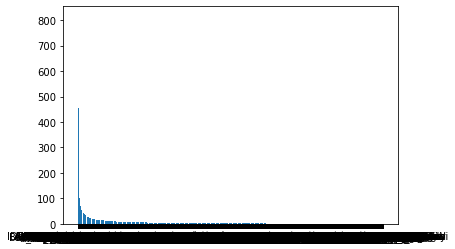

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

x= dst_users.toPandas()['user_name'].values.tolist()
y= dst_users.toPandas()['count(1)'].values.tolist()

plt.bar(x,y)
plt.show()